In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df_gamma = pd.read_csv('gamma-ray.csv')

display(df_gamma)

,seconds,count
0,116.0,0.0
1,112.0,0.0
2,160.0,0.0
3,51.5,0.0
4,102.0,1.0
...,...,...
95,38.7,1.0
96,41.8,0.0
97,81.7,0.0
98,88.3,0.0


In [4]:
# Model: G ~ Poisson(lambda * t)
# H0 = lamba1 = lambda2 = ... = lambda99
# HA = lambai not equal to lambdaj for some i and j

# What is(are) the most plausible parameter value(s) for the null model given the observations? Derive the MLE(s), i.e., maximum likelihood estimators. Calculate the value of the estimator(s) from the data.

total_counts = df_gamma['count'].sum()
total_time = df_gamma['seconds'].sum()
lambda_mle = total_counts / total_time

print(f"MLE for lambda: {lambda_mle:.3g}")

MLE for lambda: 0.00388


In [5]:
# Determine the rejection region at a significance level of 0.05. 
from scipy.stats import chi2

df = 99
alpha = 0.05

critical_value = chi2.ppf(1 - alpha, df)
print(f"Critical value at 0.05: {critical_value:.3g}")

Critical value at 0.05: 123


In [6]:
# Given the observed data, the value of the test statistic is: 

# Data already loaded as df with columns "counts" and "time"
counts = df_gamma["count"].to_numpy()
times = df_gamma["seconds"].to_numpy()

# Null MLE (common lambda)
lambda_hat = counts.sum() / times.sum()

# Alternative MLEs (interval-specific lambdas)
lambda_hats_alt = counts / times
lambda_hats_alt = np.where(times > 0, lambda_hats_alt, 0)

# Deviance (likelihood ratio statistic)
# Formula: 2 * sum[ G_i * log(G_i/(lambda_hat*t_i)) + lambda_hat*t_i - G_i ]
# Convention: 0 * log(0/μ) = 0 when G_i=0
mu_null = lambda_hat * times
terms = np.zeros_like(counts, dtype=float)

for i, (g, mu) in enumerate(zip(counts, mu_null)):
    if g == 0:
        terms[i] = mu  # since g*log(g/mu)=0, then term = mu - 0
    else:
        terms[i] = g * np.log(g / mu) + mu - g

test_statistic = 2 * terms.sum()

# Critical value at alpha=0.05, df=98
df_chi = len(counts) - 1
alpha = 0.05
critical_value = chi2.ppf(1 - alpha, df_chi)

# p-value
p_value = 1 - chi2.cdf(test_statistic, df_chi)

(test_statistic, critical_value, p_value)

(104.39792133021312, 123.2252214533618, 0.3357666240250994)

## Problem 1.4 - Gene Expression



In [7]:
# The data set golub consists of the expression levels of 3051 genes for 38 tumor mRNA samples. Each tumor mRNA sample comes from one patient (i.e. 38 patients total), and 27 of these tumor samples correspond to acute lymphoblastic leukemia (ALL) and the remaining 11 to acute myeloid leukemia (AML).

# You will need to discover how many genes can be used to differentiate the tumor types (meaning that their expression level differs between the two tumor types) using the uncorrected p-values, the Holm-Bonferroni correction, and (iii) the Benjamini-Hochberg correction?

# 38 patients -- map to golub_cl.csv to get the ALL or AML flag
# 3051 genes
# 27 tumors = ALL
# 11 tumors = AML

In [8]:
import zipfile

with zipfile.ZipFile("release_statsreview_release1.zip") as zip_file:
    golub_data, golub_classnames = ( np.genfromtxt(zip_file.open('data_and_materials/golub_data/{}'.format(fname)), delimiter=',', names=True, converters={0: lambda s: int(s.strip(b'"'))}) for fname in ['golub.csv', 'golub_cl.csv'] )

In [9]:
df_golub = pd.read_csv('golub_data/golub.csv')
df_golub = df_golub.rename(columns={df_golub.columns[0]: 'id'})

display(df_golub)

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38
0,1,-1.45769,-1.39420,-1.42779,-1.40715,-1.42668,-1.21719,-1.37386,-1.36832,-1.47649,...,-1.08902,-1.29865,-1.26183,-1.44434,1.10147,-1.34158,-1.22961,-0.75919,0.84905,-0.66465
1,2,-0.75161,-1.26278,-0.09052,-0.99596,-1.24245,-0.69242,-1.37386,-0.50803,-1.04533,...,-1.08902,-1.05094,-1.26183,-1.25918,0.97813,-0.79357,-1.22961,-0.71792,0.45127,-0.45804
2,3,0.45695,-0.09654,0.90325,-0.07194,0.03232,0.09713,-0.11978,0.23381,0.23987,...,-0.43377,-0.10823,-0.29385,0.05067,1.69430,-0.12472,0.04609,0.24347,0.90774,0.46509
3,4,3.13533,0.21415,2.08754,2.23467,0.93811,2.24089,3.36576,1.97859,2.66468,...,0.29598,-1.29865,2.76869,2.08960,0.70003,0.13854,1.75908,0.06151,1.30297,0.58186
4,5,2.76569,-1.27045,1.60433,1.53182,1.63728,1.85697,3.01847,1.12853,2.17016,...,-1.08902,-1.29865,2.00518,1.17454,-1.47218,-1.34158,1.55086,-1.18107,1.01596,0.15788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,3047,0.04695,0.48704,0.72170,0.58403,0.30600,1.10563,0.59002,0.30773,0.46515,...,0.39585,0.35006,0.32939,0.55791,0.11369,0.77377,-0.05275,0.93171,0.01243,0.86634
3047,3048,-0.20467,-0.07832,-1.00615,-0.88748,0.07175,-0.71376,-0.98900,-0.36098,-0.99075,...,-0.13951,-0.01776,-0.57690,-0.13350,-0.33722,-1.04023,-0.71434,-0.08540,-0.30978,-0.24197
3048,3049,0.45231,0.42686,0.67579,0.31524,-0.57779,0.51322,0.89885,1.26549,0.24663,...,-0.13281,0.35006,0.32333,0.75559,1.22578,0.59945,0.72956,0.72762,1.10466,1.16990
3049,3050,-0.35920,-0.43633,0.34031,-0.90930,-0.36663,-0.07845,0.09493,-0.00563,-0.32967,...,-1.08902,-0.62199,-0.11319,-0.51073,-0.68539,0.23005,-0.17911,-0.37737,-0.39063,0.33975


In [10]:
df_golub_cl = pd.read_csv('golub_data/golub_cl.csv')
df_golub_cl = df_golub_cl.rename(columns=
    {
        df_golub_cl.columns[0]: 'patient_id',
        df_golub_cl.columns[1]: 'class'
    }
)

display(df_golub_cl)

,patient_id,class
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [11]:
N_ALL = df_golub_cl['class'].value_counts()[0]
N_AML = df_golub_cl['class'].value_counts()[1]

print(f"N_ALL: {N_ALL} and N_AML: {N_AML}")

N_ALL: 27 and N_AML: 11


In [12]:
from scipy.stats import ttest_ind

# gene expression data frame
expr = df_golub.set_index('id')

# get class labels as numpy array
classes = df_golub_cl['class'].to_numpy()

# apply welch's t-test to each gene
# p_values = expr.apply(
#     lambda row: ttest_ind(
#         row[classes == 0], # ALL
#         row[classes == 1], # AML
#         equal_var=False
#     ).pvalue, axis=1
# )

# Apply Welch's t-test to each gene and return t-statistic and p-value
results = expr.apply(
    lambda row: ttest_ind(
        row[classes == 0],  # ALL
        row[classes == 1],  # AML
        equal_var=False
    ),
    axis=1,
    result_type='expand'  # Ensures the result is expanded into a DataFrame
)

# Rename the columns for clarity
results.columns = ['t_stat', 'p_value']

display(results)

,t_stat,p_value
id,,
1,-1.759195,0.106169
2,-0.909858,0.380091
3,0.098026,0.923211
4,0.338963,0.736901
5,1.370165,0.182273
...,...,...
3047,-0.041362,0.967462
3048,-0.316234,0.753681
3049,-1.842529,0.079373


In [13]:
num_significant_genes = len(results[results['p_value'] <= 0.05])
print(f"Number of significant genes at 0.05: {num_significant_genes}")

Number of significant genes at 0.05: 1078


In [14]:
# alt method using regression

import statsmodels.api as sm

# Prepare the data
expr = df_golub.set_index('id')  # Rows = genes, Columns = samples
classes = df_golub_cl['class'].to_numpy()  # Class labels (0 = ALL, 1 = AML)

# Function to perform regression for each gene
def regression_ttest(row):
    y = row.values  # Gene expression values (dependent variable)
    X = sm.add_constant(classes)  # Add intercept to class labels (independent variable)
    model = sm.OLS(y, X).fit()  # Fit ordinary least squares regression
    t_stat = model.tvalues[1]  # t-statistic for the class coefficient
    p_value = model.pvalues[1]  # p-value for the class coefficient
    return pd.Series({'t_stat': t_stat, 'p_value': p_value})

# Apply the regression-based t-test to each gene
results_regression = expr.apply(regression_ttest, axis=1)

display(results_regression)

,t_stat,p_value
id,,
1,2.502107,0.017028
2,1.156167,0.255228
3,-0.109986,0.913031
4,-0.272658,0.786674
5,-1.186627,0.243147
...,...,...
3047,0.042022,0.966714
3048,0.236435,0.814435
3049,1.735692,0.091172


In [15]:
num_significant_genes_regression = len(results_regression[results_regression['p_value'] <= 0.05])
print(f"Number of significant genes at 0.05: {num_significant_genes_regression}")

Number of significant genes at 0.05: 1045


In [16]:
len(df_golub)

3051

In [17]:
# bonferroni correction - divide alpha by number of tests or multiply p-values by no. of tests

results['bf_adj_pval'] = results['p_value'] * len(df_golub)
#results['bf_adj_pval'] = results['bf_adj_pval'].clip(upper=1)

display(results)

,t_stat,p_value,bf_adj_pval
id,,,
1,-1.759195,0.106169,323.921358
2,-0.909858,0.380091,1159.658955
3,0.098026,0.923211,2816.717137
4,0.338963,0.736901,2248.285136
5,1.370165,0.182273,556.113508
...,...,...,...
3047,-0.041362,0.967462,2951.726472
3048,-0.316234,0.753681,2299.481241
3049,-1.842529,0.079373,242.166325


In [18]:
num_significant_genes_bf = len(results[results['bf_adj_pval'] <= 0.05])
print(f"Number of significant genes after Bonferroni Correction at 0.05: {num_significant_genes_bf}")

Number of significant genes after Bonferroni Correction at 0.05: 103


In [19]:
# benjamini hochberg correction
from scipy import stats

results['bh_adj_pval'] = stats.false_discovery_control(results['p_value'])

display(results)

,t_stat,p_value,bf_adj_pval,bh_adj_pval
id,,,,
1,-1.759195,0.106169,323.921358,0.238353
2,-0.909858,0.380091,1159.658955,0.556191
3,0.098026,0.923211,2816.717137,0.960354
4,0.338963,0.736901,2248.285136,0.841521
5,1.370165,0.182273,556.113508,0.343280
...,...,...,...,...
3047,-0.041362,0.967462,2951.726472,0.984242
3048,-0.316234,0.753681,2299.481241,0.854508
3049,-1.842529,0.079373,242.166325,0.195611


In [20]:
num_significant_genes_bh = len(results[results['bh_adj_pval'] <= 0.05])
print(f"Number of significant genes after Benjamini Hochberg Correction at 0.05: {num_significant_genes_bh}")

Number of significant genes after Benjamini Hochberg Correction at 0.05: 695


In [21]:
from statsmodels.stats.multitest import multipletests

# Apply Benjamini-Hochberg correction
_, bh_adj_pvals, _, _ = multipletests(results['p_value'], alpha=0.05, method='fdr_bh')

# Add the adjusted p-values to the DataFrame
results['bh_adj_pval2'] = bh_adj_pvals

# Display the results
display(results)

,t_stat,p_value,bf_adj_pval,bh_adj_pval,bh_adj_pval2
id,,,,,
1,-1.759195,0.106169,323.921358,0.238353,0.238353
2,-0.909858,0.380091,1159.658955,0.556191,0.556191
3,0.098026,0.923211,2816.717137,0.960354,0.960354
4,0.338963,0.736901,2248.285136,0.841521,0.841521
5,1.370165,0.182273,556.113508,0.343280,0.343280
...,...,...,...,...,...
3047,-0.041362,0.967462,2951.726472,0.984242,0.984242
3048,-0.316234,0.753681,2299.481241,0.854508,0.854508
3049,-1.842529,0.079373,242.166325,0.195611,0.195611


In [22]:
num_significant_genes_bh = len(results[results['bh_adj_pval2'] <= 0.05])
print(f"Number of significant genes after Benjamini Hochberg Correction at 0.05: {num_significant_genes_bh}")

Number of significant genes after Benjamini Hochberg Correction at 0.05: 695


# Problem 1.6 - OLS & GD

In [23]:
df_syn_X = pd.read_csv('syn_X.csv', header=None)
df_syn_Y = pd.read_csv('syn_Y.csv', header=None)

In [24]:
def add_intercept(X):
  return np.concatenate((np.ones_like(X[:,:1]), X), axis=1)

df_syn_X = pd.concat([pd.Series(1, index=df_syn_X.index, name='Intercept'), df_syn_X], axis=1)


In [25]:
display(df_syn_X)

,Intercept,0,1
0,1,0.537670,0.84038
1,1,1.833900,-0.88803
2,1,-2.258800,0.10009
3,1,0.862170,-0.54453
4,1,0.318770,0.30352
...,...,...,...
95,1,0.187330,0.82606
96,1,-0.082494,1.52700
97,1,-1.933000,0.46691
98,1,-0.438970,-0.20971


In [26]:
display(df_syn_Y)

,0
0,-1.04490
1,7.68190
2,-0.68642
3,5.63850
4,1.08430
...,...
95,-1.52790
96,-6.21350
97,-2.13020
98,1.32070


In [27]:
# OLS estimator using matrix inversion
# (Xt @ X)^-1 @ Xt @ y

X = df_syn_X.to_numpy()
y = df_syn_Y.to_numpy()

beta = np.linalg.inv(X.T @ X) @ X.T @ y

display(np.round(beta,3))

array([[ 1.93 ],
       [ 1.264],
       [-4.598]])

In [33]:
def gradient_descent(X, y, step_size=0.01, precision=1e-6, max_iters=1000):
    """
    Perform gradient descent to minimize the cost function for linear regression.

    Parameters:
        X (numpy.ndarray): Feature matrix (with intercept column if needed).
        y (numpy.ndarray): Target vector.
        step_size (float): Learning rate for gradient descent.
        precision (float): Convergence threshold for stopping.
        max_iters (int): Maximum number of iterations.

    Returns:
        beta (numpy.ndarray): Coefficients for the linear regression model.
    """
    # Ensure y is a 2D column vector
    if y.ndim == 1:
        y = y.reshape(-1, 1)
    
    # Initialize beta (coefficients) with zeros
    beta = np.zeros((X.shape[1], 1))
    
    # Gradient descent loop
    for i in range(max_iters):
        # Calculate predictions
        y_pred = X @ beta
        
        # Compute the gradient of the cost function
        gradient = -(2 / len(y)) * (X.T @ (y - y_pred))
        
        # Update beta
        beta_new = beta - step_size * gradient
        
        # Check for convergence
        if np.linalg.norm(beta_new - beta, ord=2) < precision:
            print(f"Converged in {i+1} iterations.")
            break
        
        beta = beta_new
    
    return beta.flatten()  # Return beta as a 1D array

In [34]:
X = df_syn_X.to_numpy()
y = df_syn_Y.to_numpy()

beta = gradient_descent(X=X, y=y, step_size=0.43)

print(beta)

Converged in 11 iterations.
[ 1.92960679  1.26397051 -4.59799263]


In [39]:
import numpy as np

def gradient_descent(X, y, step_size, precision):
    """
    Performs gradient descent for linear regression.
    
    Parameters:
    - X: numpy array of shape (n_samples, n_features), with intercept already included
    - y: numpy array of shape (n_samples,) or (n_samples, 1)
    - step_size: float, learning rate
    - precision: float, convergence threshold
    
    Returns:
    - w: optimized weights (shape: (n_features,))
    - cost_history: list of cost values over iterations
    - num_iterations: int, total number of iterations run
    """
    
    # Ensure X is 2D and has correct shape
    X = np.array(X)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Ensure y is 1D
    y = np.array(y).flatten()

    n_samples, n_features = X.shape

    # Initialize weights
    w = np.zeros(n_features)

    # Cost history
    cost_history = []
    prev_cost = float('inf')
    num_iterations = 0

    while True:
        # Predictions
        y_pred = X @ w

        # Error
        error = y_pred - y

        # Mean squared error (MSE)
        cost = np.mean(error ** 2)
        cost_history.append(cost)

        # Check convergence
        if abs(prev_cost - cost) < precision:
            break
        prev_cost = cost

        # Gradient: d(MSE)/dw = (2/n) * X.T @ (X@w - y)
        gradient = (2 / n_samples) * (X.T @ error)

        # Update weights
        w = w - step_size * gradient

        num_iterations += 1

    return w, cost_history, num_iterations

Learned weights: [ 1.92966906  1.26396145 -4.59793942]
Number of iterations: 7


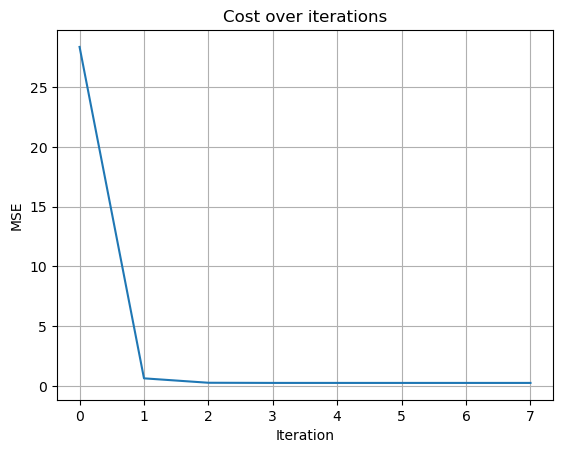

In [51]:

# Run gradient descent
w, costs, num_iters = gradient_descent(X, y, step_size=0.43, precision=1e-6)

print("Learned weights:", w)
print("Number of iterations:", num_iters)

# Plot cost over iterations
import matplotlib.pyplot as plt
plt.plot(costs)
plt.title("Cost over iterations")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

In [70]:
# GM data

# Read mortality data as pandas DataFrame
df_mortality = pd.read_csv('mortality.csv')

display(df_mortality)

,City,Mortality,JanTemp,JulyTemp,RelHum,Rain,Educ,Dens,NonWhite,WhiteCollar,Pop,House,Income,HC,NOx,SO2
0,"Akron, OH",921.87,27,71,59,36,11.4,3243,8.8,42.6,660328,3.34,29560,21,15,59
1,"Albany-Schenectady-Troy, NY",997.87,23,72,57,35,11.0,4281,3.5,50.7,835880,3.14,31458,8,10,39
2,"Allentown, Bethlehem,PA-NJ",962.35,29,74,54,44,9.8,4260,0.8,39.4,635481,3.21,31856,6,6,33
3,"Atlanta, GA",982.29,45,79,56,47,11.1,3125,27.1,50.2,2138231,3.41,32452,18,8,24
4,"Baltimore, MD",1071.29,35,77,55,43,9.6,6441,24.4,43.7,2199531,3.44,32368,43,38,206
5,"Birmingham, AL",1030.38,45,80,54,53,10.2,3325,38.5,43.1,883946,3.45,27835,30,32,72
6,"Boston, MA",934.70,30,74,56,43,12.1,4679,3.5,49.2,2805911,3.23,36644,21,32,62
7,"Bridgeport-Milford, CT",899.53,30,73,56,45,10.6,2140,5.3,40.4,438557,3.29,47258,6,4,4
8,"Buffalo, NY",1001.90,24,70,61,36,10.5,6582,8.1,42.5,1015472,3.31,31248,18,12,37
9,"Canton, OH",912.35,27,72,59,36,10.7,4213,6.7,41.0,404421,3.36,29089,12,7,20


In [73]:
# Set up X and y for gradient descent with Mortality as dependent variable
# Get all columns except 'Mortality' for independent variables
numeric_cols = df_mortality.select_dtypes(include=[np.number]).columns.tolist()
X_cols = [col for col in numeric_cols if col != 'Mortality']

# Create X matrix (independent variables) and add intercept
X_data = df_mortality[X_cols].to_numpy()
X = np.column_stack([np.ones(len(df_mortality)), X_data])  # Add intercept column

# Set y as the Mortality values
y = df_mortality['Mortality'].to_numpy()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Independent variables: {X_cols}")

X shape: (59, 15)
y shape: (59,)
Independent variables: ['JanTemp', 'JulyTemp', 'RelHum', 'Rain', 'Educ', 'Dens', 'NonWhite', 'WhiteCollar', 'Pop', 'House', 'Income', 'HC', 'NOx', 'SO2']


In [88]:

# Run gradient descent
w, costs, num_iters = gradient_descent(X, y, step_size=0.01, precision=1e-6)

print("Learned weights:", w)
print("Number of iterations:", num_iters)

# Plot cost over iterations
import matplotlib.pyplot as plt
plt.plot(costs)
plt.title("Cost over iterations")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

/var/folders/kj/43wdr9t108505m0kvphrlw2r0000gn/T/ipykernel_17432/1654992699.py:45: RuntimeWarning: overflow encountered in square
  cost = np.mean(error ** 2)
/var/folders/kj/43wdr9t108505m0kvphrlw2r0000gn/T/ipykernel_17432/1654992699.py:49: RuntimeWarning: invalid value encountered in scalar subtract
  if abs(prev_cost - cost) < precision:
/var/folders/kj/43wdr9t108505m0kvphrlw2r0000gn/T/ipykernel_17432/1654992699.py:39: RuntimeWarning: overflow encountered in matmul
  y_pred = X @ w
/var/folders/kj/43wdr9t108505m0kvphrlw2r0000gn/T/ipykernel_17432/1654992699.py:57: RuntimeWarning: invalid value encountered in subtract
  w = w - step_size * gradient


KeyboardInterrupt: 

Learned weights: 0.000, -0.240, -0.215, 0.009, 0.207, -0.142, 0.107, 0.770, -0.134, 0.076, -0.103, -0.026, -0.399, 0.277, 0.172
Weight-Column mapping:
  Intercept: 0.0000
  JanTemp: -0.2401
  JulyTemp: -0.2145
  RelHum: 0.0090
  Rain: 0.2066
  Educ: -0.1425
  Dens: 0.1073
  NonWhite: 0.7696
  WhiteCollar: -0.1335
  Pop: 0.0755
  House: -0.1027
  Income: -0.0256
  HC: -0.3985
  NOx: 0.2766
  SO2: 0.1723
Number of iterations: 3591


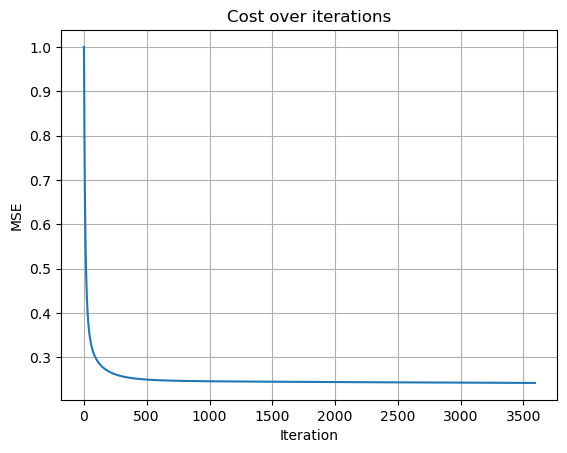

In [87]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Now run gradient descent on X_scaled, y_scaled
w, costs, iters = gradient_descent(X_scaled, y_scaled, step_size=0.01, precision=1e-6)

# Create column names including intercept
column_names = ['Intercept'] + X_cols

# Print weights with their corresponding column names
print("Learned weights:", ", ".join([f"{weight:.3f}" for weight in w]))
print("Weight-Column mapping:")
for i, (weight, col_name) in enumerate(zip(w, column_names)):
    print(f"  {col_name}: {weight:.4f}")

print("Number of iterations:", iters)

# Plot cost over iterations
import matplotlib.pyplot as plt
plt.plot(costs)
plt.title("Cost over iterations")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

In [ ]:
# Analyze residuals from current model to identify transformation needs
from sklearn.linear_model import LinearRegression

# Fit a linear regression model
lr_model = LinearRegression()
lr_model.fit(X, y)
y_pred = lr_model.predict(X)
residuals = y - y_pred

# Plot residuals vs fitted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Plot residuals vs each predictor variable
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(X_cols):
    if i < len(axes):
        axes[i].scatter(df_mortality[col], residuals, alpha=0.7)
        axes[i].axhline(y=0, color='r', linestyle='--')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Residuals')
        axes[i].set_title(f'Residuals vs {col}')

# Remove empty subplots
for i in range(len(X_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
# Check which variables are candidates for log transformation
# Variables that are good candidates typically have:
# 1. Right-skewed distributions (skewness > 1)
# 2. Wide range of values
# 3. All positive values (required for log transformation)

print("Variable Analysis for Log Transformation:")
print("=" * 50)

for col in X_cols + ['Mortality']:
    data = df_mortality[col]
    
    # Check if all values are positive (required for log transformation)
    all_positive = (data > 0).all()
    
    # Calculate skewness
    skewness = stats.skew(data)
    
    # Calculate range ratio (max/min)
    range_ratio = data.max() / data.min() if data.min() > 0 else float('inf')
    
    print(f"\n{col}:")
    print(f"  All positive: {all_positive}")
    print(f"  Skewness: {skewness:.3f}")
    print(f"  Range ratio (max/min): {range_ratio:.2f}")
    print(f"  Min: {data.min():.2f}, Max: {data.max():.2f}")
    
    # Suggest log transformation if criteria are met
    if all_positive and skewness > 1 and range_ratio > 10:
        print(f"  *** CANDIDATE for log transformation ***")
    elif all_positive and (skewness > 0.5 or range_ratio > 5):
        print(f"  ** Possible candidate for log transformation **")
    else:
        print(f"  - Unlikely to benefit from log transformation")